In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import shap
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import pickle

In [2]:
def get_bounding_box_ratio(row):
    x1, y1, x2, y2 = row.bbox_x1, row.bbox_y1, row.bbox_x2, row.bbox_y2
    return (x2 - x1) / (y2 - y1)

In [3]:
def get_ratios(df):
    ratios_df = df.copy()
    ratios_df['ratio'] = ratios_df.apply(get_bounding_box_ratio, axis = 1) 
    return ratios_df

In [4]:
def drop_columns(df):
    lms_to_keep = [ 4, 6, 8, 10, 12, 14, 16, 18, 20]
    # lms_to_keep = [0, 4, 8, 12, 16, 20]
    xs = [f'x{i}' for i in range(21) if i not in lms_to_keep]
    ys = [f'y{i}' for i in range(21) if i not in lms_to_keep]
    drop_cols = ['video', 'handedness', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']
    return df.drop(columns = xs + ys + drop_cols)

In [5]:
def drop_na(df):
    return df.dropna(subset=['iou2'])

In [6]:
def draw_heatmap(df, cols):
    corr_matrix = df[cols].corr()

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Selected Features')
    plt.show()

In [7]:
def get_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size = 0.20, 
        random_state = 42, 
        stratify = y
    )
    return X_train, X_test, y_train, y_test

# Bulgarian Sign Language (Alphabet) Detector #

<br/>
This project aims to create a model that can detect the letters in the bulgarian alphabet in a video/stream. To do so, several steps have been taken, starting from the collection of the dataset. 
<ol>
    <li>
        Collect videos of people doing the signs - They have not been added to the repo/zip because of the size but can still be acessed through <a href='https://drive.google.com/drive/folders/101l61bluVN9f49zUGeR_AVPxk6osSpeX?usp=sharing'>this link</a>. Most of the people have used <a href='https://www.youtube.com/watch?v=8YmTxIp2Gtg'>this video</a> to learn the sign from, one person used a different tutorial video in which the forms are different (mostly their angle)
    </li>
    <li>
        Extract images (frames) from these videos and labeling them - link to file
    </li>
    <li>
        Using those frames to create the dataset
    </li>
    <li>
        Using the dataset to create a model
    </li>
    <li>
        Trying it out in real time - link to file
    </li>
</ol>

The dataset is a table where each sample is a frame, containing information about the hand landmarks, bounding box coordinates and the calculated Interception over Union for 3 samples back. Samples are taken from each video with a 5 frame step. So the samples will have IoU between itself and 5, 10 and 15 frames back. Most of the videos are 30fps - we have "history" up to half a second ago.

This project has several things to keep in mind:
<uol>
    <li>Small dataset (who knew collecting data wasn't easy)</li>
    <li>Multinomial Classificaiton with 30 classes</li>
    <li>For a few letters, the only way to distinguish them is by their movement</li>
    <li>The hand landmarks which will be the primary source of information are not truly independent</li>
</uol>


## Data processing ##

In [1060]:
hands = pd.read_csv('hands_data.csv')
hands = hands.drop(columns = 'Unnamed: 0')

In [1061]:
hands = get_ratios(hands)

In [1062]:
selected_columns = ['letter', 'x0', 'x4', 'x8', 'x12', 'x16', 'x20', 'y0', 'y4', 'y8', 'y12', 'y16', 'y20', 'ratio', 'iou1', 'iou2', 'iou0']

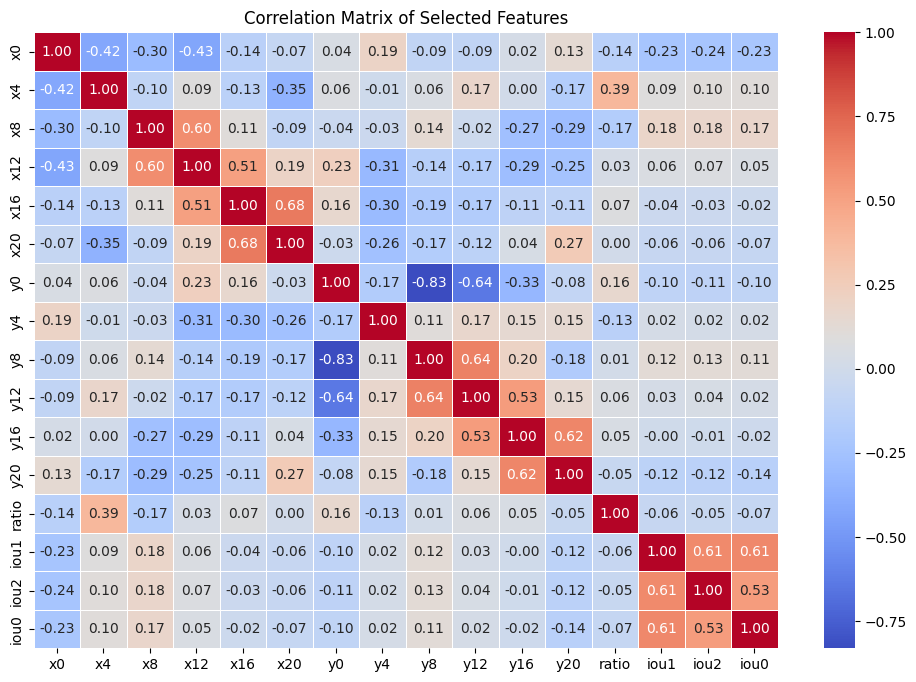

In [1063]:
# Calculate the correlation matrix
corr_matrix = hands[selected_columns].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

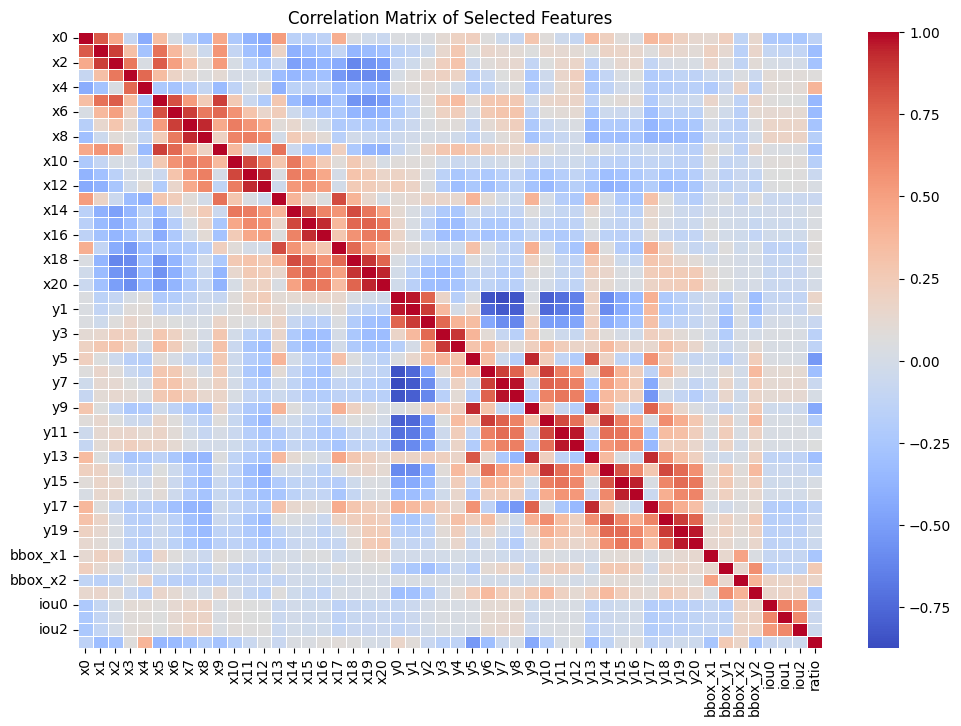

In [1064]:
selected_columns = ['letter', 'x0', 'x4', 'x8', 'x12', 'x16', 'x20', 'y0', 'y4', 'y8', 'y12', 'y16', 'y20', 'ratio', 'iou1', 'iou2', 'iou0']

# Calculate the correlation matrix
corr_matrix = hands.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

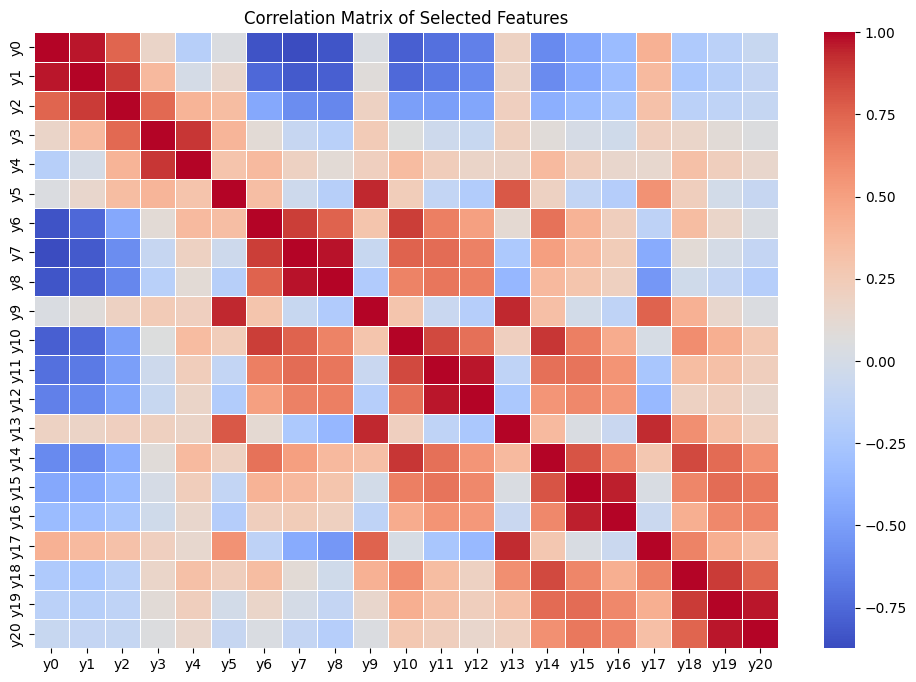

In [1065]:
ys = [f'y{i}' for i in range(21)]

# Calculate the correlation matrix
corr_matrix = hands[ys].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

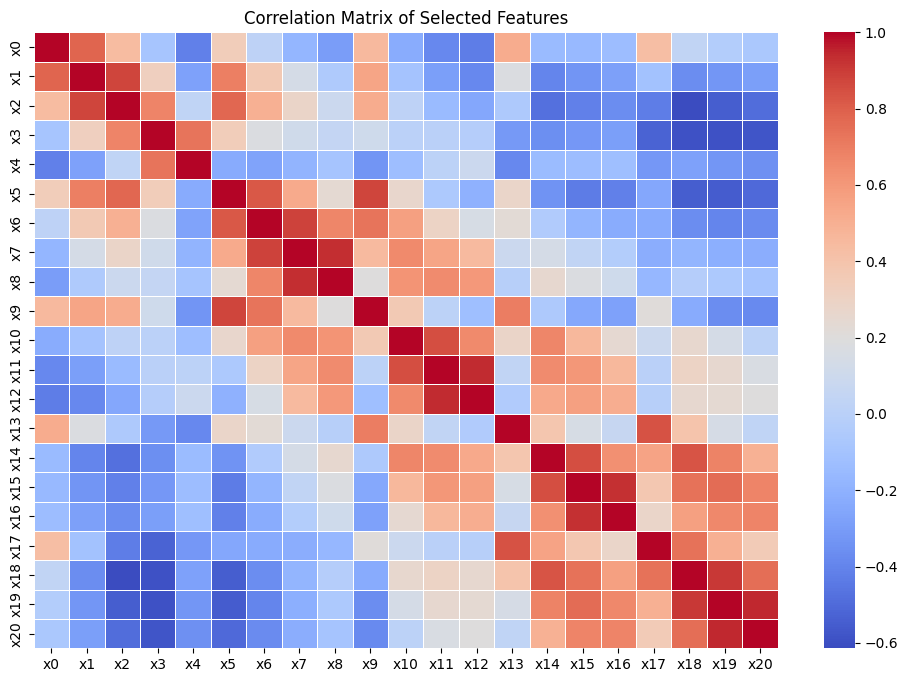

In [1066]:
selected_columns = [f'x{i}' for i in range(21)]

# Calculate the correlation matrix
corr_matrix = hands[selected_columns].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

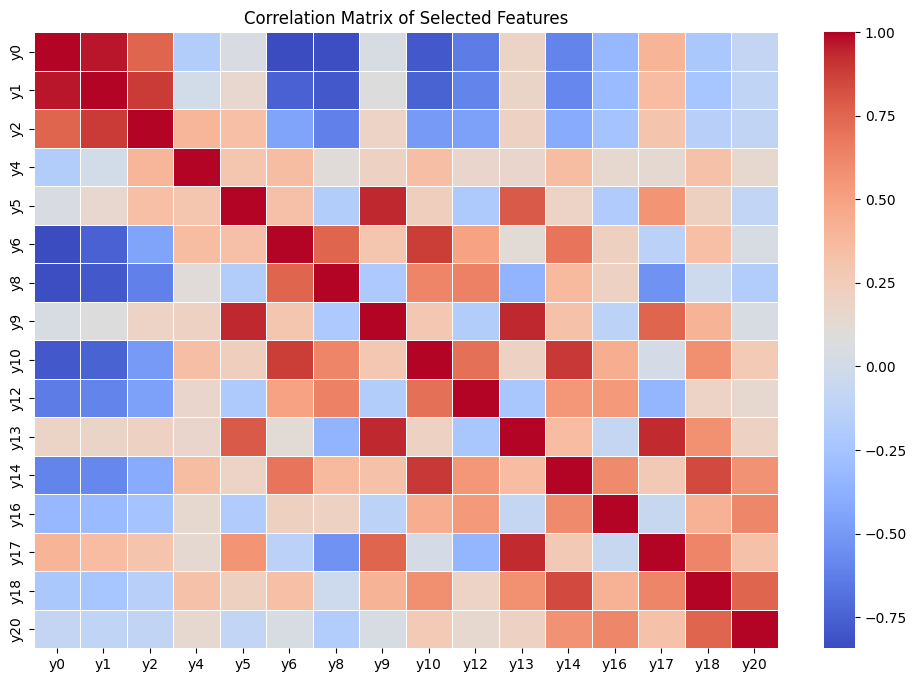

In [1067]:
filtered_y = [f'y{i}' for i in range(21) if i not in [3, 7, 11, 15, 19]]
draw_heatmap(hands, filtered_y)

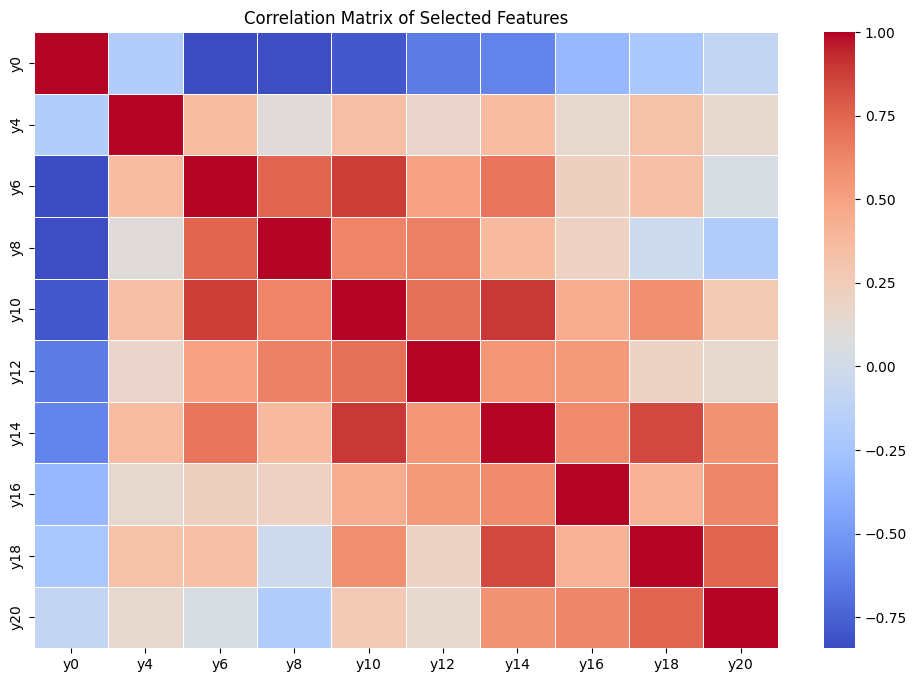

In [1068]:
filtered_y = [f'y{i}' for i in range(21) if i in [0, 4, 6, 8, 10, 12, 14, 16, 18, 20]]
draw_heatmap(hands, filtered_y)

### Manual Feature Selection ###
Dropping some landmarks that objectively don't carry information about the sign (e.g. knuckles, the little joints of the fingers)

In [17]:
hands = pd.read_csv('hands_data.csv')
hands = hands.drop(columns = 'Unnamed: 0')
hands = drop_na(hands)
# hands = get_ratios(hands)

In [18]:
# TO DOOO 
# drop letter
# train test split

X = hands.drop(columns = 'letter')
y = hands.letter.astype('category')

X_train, X_test, y_train, y_test = get_train_test(X, y)

In [19]:
pipeline = Pipeline([
    ('get_ratios', FunctionTransformer(get_ratios)),
    ('drop_columns', FunctionTransformer(drop_columns)),
])

X_train = pipeline.fit_transform(X_train)

# print(X_train)

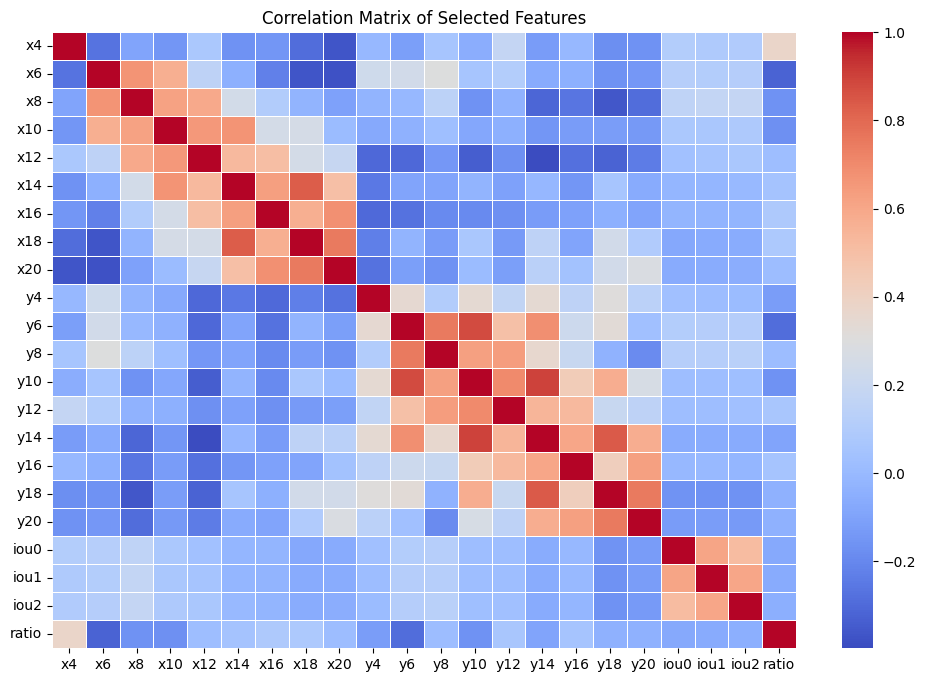

In [20]:
draw_heatmap(X_train, X_train.columns)

In [21]:
X_train

,x4,x6,x8,x10,x12,x14,x16,x18,x20,y4,...,y10,y12,y14,y16,y18,y20,iou0,iou1,iou2,ratio
399,0.755698,0.593613,0.452650,0.419479,0.324398,0.271181,0.208180,0.093052,0.000000,0.465932,...,0.270715,0.000000,0.329744,0.076995,0.455982,0.261008,0.151926,0.567210,0.559999,0.963553
4337,1.000000,0.554321,0.627104,0.425691,0.425462,0.290497,0.307624,0.132295,0.190419,0.650871,...,0.469595,0.761225,0.568683,0.808900,0.608574,0.766497,0.954183,0.367742,0.353198,1.387906
1163,0.459429,0.602489,0.453157,0.281016,0.494102,0.080456,0.371564,0.000000,0.283256,0.506329,...,0.239789,0.536955,0.416905,0.606674,0.636777,0.711576,0.464612,0.569323,0.570245,1.092469
4371,1.000000,0.351625,0.375346,0.455510,0.417613,0.363029,0.327741,0.238509,0.246504,0.409068,...,0.582767,0.800650,0.712611,0.845824,0.811455,0.890444,0.072136,0.594008,0.479276,1.689360
2710,1.000000,0.638475,0.936759,0.582182,0.933502,0.505068,0.809958,0.398333,0.612031,0.824743,...,0.038686,0.034142,0.082062,0.037024,0.222115,0.066641,0.866431,0.848136,0.820668,2.009560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2045,0.416113,0.957477,1.000000,0.634059,0.554610,0.377050,0.395197,0.168797,0.000000,0.683661,...,0.296303,0.000000,0.420932,0.618528,0.471974,0.302901,0.865772,0.717965,0.611537,1.078958
3761,0.384070,0.678928,0.434436,0.283602,0.499216,0.076207,0.403775,0.000000,0.297380,0.334292,...,0.236390,0.635210,0.290670,0.630359,0.348860,0.622925,0.419754,0.661284,0.664286,1.434367
467,1.000000,0.502639,0.439125,0.338743,0.309448,0.193883,0.156991,0.047176,0.027337,0.240046,...,0.685887,0.465569,0.674821,0.479797,0.631702,0.459968,0.826534,0.835736,0.899646,1.396852
3064,0.396733,0.899617,0.674201,0.928376,0.719841,0.928096,0.728252,0.782811,1.000000,0.000000,...,0.552838,0.533975,0.680585,0.637984,0.894657,1.000000,0.722716,0.610905,0.669371,1.243409


## Algorithm selection ##

In [11]:
def print_score_res(scores):
    print(f"Mean accuracy: {scores['test_accuracy'].mean():.2f}")
    print(f"Standard deviation: {scores['test_accuracy'].std():.2f}\n")
    print(f"Mean precision_macro: {scores['test_precision_macro'].mean():.2f}")
    print(f"Standard deviation: {scores['test_precision_macro'].std():.2f}\n")
    print(f"Mean recall_macro: {scores['test_recall_macro'].mean():.2f}")
    print(f"Standard deviation: {scores['test_recall_macro'].std():.2f}\n")
    print(f"Mean f1_macro: {scores['test_f1_macro'].mean():.2f}")
    print(f"Standard deviation: {scores['test_f1_macro'].std():.2f}\n")

"stratified random splits do not guarantee that test sets across all folds will be mutually exclusive, and might include overlapping samples. " - sklearn

In [12]:
def get_stratified_shuffle_split_score(model):
    cv = StratifiedShuffleSplit(n_splits = 10)
    scores = cross_validate(model, X_train, y_train, cv = cv, 
                            scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'] )
    print('CV with stratified shuffle split:')
    print_score_res(scores)

In [13]:
def get_repeated_stratified_kfold_score(model):
    cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 5, random_state = 0)
    scores = cross_validate(model, X_train, y_train, cv = cv, 
                            scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'] )
    print('CV with repeated stratified kfold:')
    print_score_res(scores)

### Decision Tree ###

In [1184]:
clf = tree.DecisionTreeClassifier(random_state = 42)
clf = clf.fit(X_train, y_train)

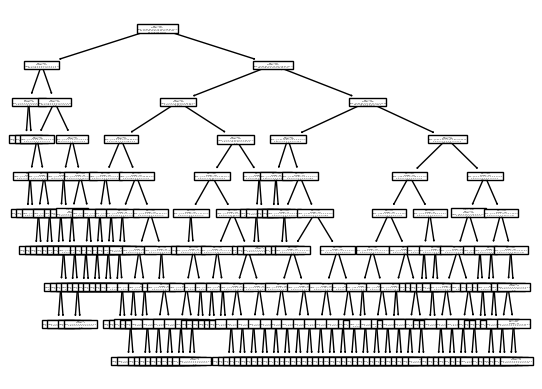

In [1074]:
tree.plot_tree(clf, feature_names = hands.columns)
plt.show()

In [1185]:
get_stratified_shuffle_split_score(clf)
get_repeated_stratified_kfold_score(clf)

CV with stratified shuffle split:
Mean accuracy: 0.90
Standard deviation: 0.02

Mean precision_macro: 0.91
Standard deviation: 0.01

Mean recall_macro: 0.91
Standard deviation: 0.02

Mean f1_macro: 0.90
Standard deviation: 0.02

CV with repeated stratified kfold:
Mean accuracy: 0.90
Standard deviation: 0.01

Mean precision_macro: 0.90
Standard deviation: 0.01

Mean recall_macro: 0.90
Standard deviation: 0.01

Mean f1_macro: 0.90
Standard deviation: 0.01



### Random Forest ###

In [14]:
rfc = RandomForestClassifier(max_depth = 10, n_estimators = 150)
rfc = rfc.fit(X_train, y_train)

In [16]:
pickle.dump(rfc, open('model.pkl','wb'))

In [36]:
rfc.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'random_state',
 'ccp_alpha')

In [1188]:
# [estimator.tree_.max_depth for estimator in rfc.estimators_]

In [16]:
rfc.score(X_train,y_train)

0.9977324263038548

In [38]:
X_train.columns

Index(['x4', 'x6', 'x8', 'x10', 'x12', 'x14', 'x16', 'x18', 'x20', 'y4', 'y6',
       'y8', 'y10', 'y12', 'y14', 'y16', 'y18', 'y20', 'iou0', 'iou1', 'iou2',
       'ratio'],
      dtype='object')

In [39]:
rfc.feature_importances_

array([0.06437682, 0.03343155, 0.04316452, 0.03905383, 0.04647228,
       0.0337855 , 0.04509268, 0.02093787, 0.05555083, 0.04947011,
       0.05678849, 0.07324044, 0.04951287, 0.07246696, 0.04539399,
       0.08667925, 0.0358735 , 0.05951699, 0.01474357, 0.01450555,
       0.01530452, 0.04463788])

In [17]:
get_stratified_shuffle_split_score(rfc)
get_repeated_stratified_kfold_score(rfc)

CV with stratified shuffle split:
Mean accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.01

Mean f1_macro: 0.97
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.96
Standard deviation: 0.01

Mean precision_macro: 0.96
Standard deviation: 0.01

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01



In [1204]:
for key, val in zip(X_train.columns,  rfc.feature_importances_):
    print (key, ': ', val)

x4 :  0.06323468629243675
x6 :  0.03569889293910583
x8 :  0.03894191106168794
x10 :  0.03629512125649893
x12 :  0.04721777342630276
x14 :  0.033470126093344495
x16 :  0.04130584254568459
x18 :  0.022164191300765797
x20 :  0.05393977533153061
y4 :  0.052401772149697295
y6 :  0.05487564572425142
y8 :  0.08153731230148631
y10 :  0.04559637331428978
y12 :  0.07516763847540645
y14 :  0.04480206312276512
y16 :  0.09082786511871489
y18 :  0.03515831670456327
y20 :  0.054258362384776264
iou0 :  0.0162412734066
iou1 :  0.01563320474835545
iou2 :  0.016296921775141995
ratio :  0.04493493052659411


100%|===================| 105834/105840 [96:19<00:00]        

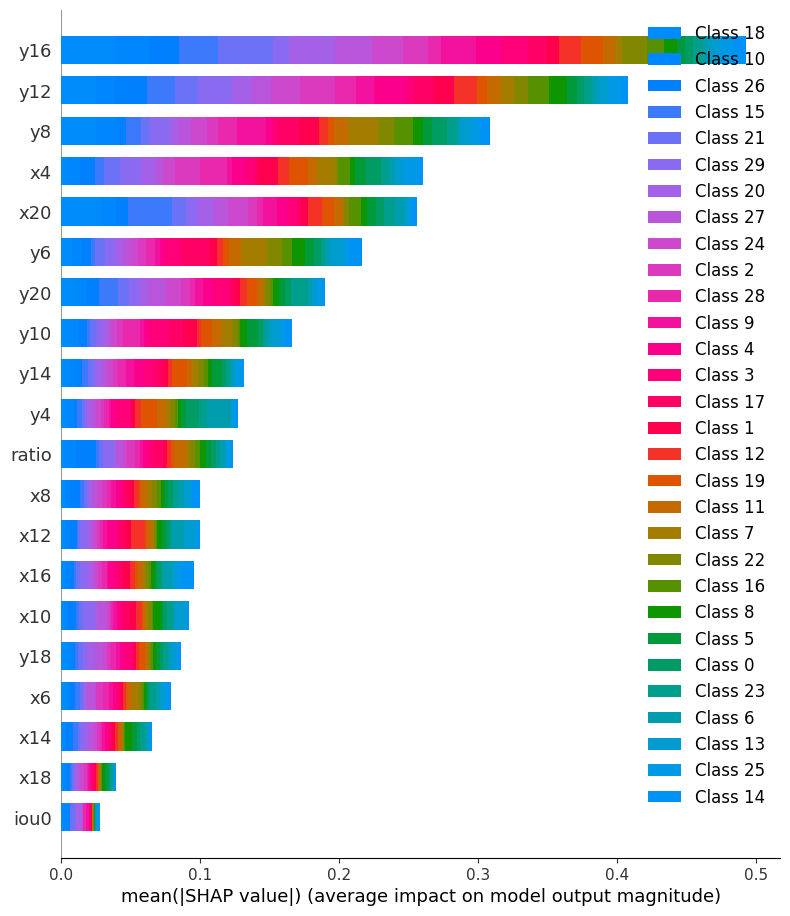

In [28]:
# explainer = shap.Explainer(svc)

# shap_values = explainer(X_train, y_train)
# shap.plots.bar(shap_values)
# plt.show()

background_sample = shap.sample(X_train, 100)  # Using 100 as an example

# Create a SHAP explainer using KernelExplainer
explainer = shap.TreeExplainer(rfc, background_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_train)

### (Multinomial) Logistic Regression ###
very slow?

In [29]:
# mlr = LogisticRegression(penalty = 'l2', C = 3.5, solver = 'lbfgs', max_iter = 1000)
mlr = LogisticRegression(penalty = 'l2', C = 10, class_weight = 'balanced', solver = 'lbfgs', max_iter = 500)
mlr = mlr.fit(X_train, y_train)

In [30]:
mlr.score(X_train, y_train)

0.9512471655328798

In [31]:
get_stratified_shuffle_split_score(mlr)
get_repeated_stratified_kfold_score(mlr)

CV with stratified shuffle split:
Mean accuracy: 0.94
Standard deviation: 0.02

Mean precision_macro: 0.94
Standard deviation: 0.02

Mean recall_macro: 0.94
Standard deviation: 0.02

Mean f1_macro: 0.94
Standard deviation: 0.02

CV with repeated stratified kfold:
Mean accuracy: 0.93
Standard deviation: 0.01

Mean precision_macro: 0.93
Standard deviation: 0.01

Mean recall_macro: 0.93
Standard deviation: 0.01

Mean f1_macro: 0.93
Standard deviation: 0.01



In [32]:
mlr = LogisticRegression(penalty = 'l2', C = 10, class_weight = 'balanced', max_iter = 500)
mlr = mlr.fit(X_train, y_train)

In [33]:
# X_test = pipeline.transform(X_test)

mlr.score(X_train, y_train)

0.9512471655328798

In [34]:
get_stratified_shuffle_split_score(mlr)
get_repeated_stratified_kfold_score(mlr)

CV with stratified shuffle split:
Mean accuracy: 0.94
Standard deviation: 0.01

Mean precision_macro: 0.94
Standard deviation: 0.01

Mean recall_macro: 0.94
Standard deviation: 0.01

Mean f1_macro: 0.94
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.93
Standard deviation: 0.01

Mean precision_macro: 0.93
Standard deviation: 0.01

Mean recall_macro: 0.93
Standard deviation: 0.01

Mean f1_macro: 0.93
Standard deviation: 0.01



### OVR with Logistic Regression ###

In [1093]:
lr = LogisticRegression(penalty = 'l2', C = 100, solver = 'lbfgs',  max_iter = 500)
ovr = OneVsRestClassifier(lr)
ovr = ovr.fit(X_train, y_train)

In [1094]:
ovr.score(X_train, y_train)

0.9508692365835223

In [1095]:
get_stratified_shuffle_split_score(ovr)
get_repeated_stratified_kfold_score(ovr)

CV with stratified shuffle split:
Mean accuracy: 0.94
Standard deviation: 0.01

Mean precision_macro: 0.94
Standard deviation: 0.01

Mean recall_macro: 0.94
Standard deviation: 0.01

Mean f1_macro: 0.94
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.93
Standard deviation: 0.01

Mean precision_macro: 0.93
Standard deviation: 0.01

Mean recall_macro: 0.93
Standard deviation: 0.01

Mean f1_macro: 0.93
Standard deviation: 0.01



### SVC ###

In [19]:
svc = SVC()
svc = svc.fit(X_train, y_train)

In [20]:
svc = SVC( C = 1, kernel = 'poly', degree = 3, class_weight = 'balanced', probability=True)
svc = svc.fit(X_train, y_train)

In [21]:
svc.score(X_train, y_train)

0.9855442176870748

In [1264]:
get_stratified_shuffle_split_score(svc)
get_repeated_stratified_kfold_score(svc)

CV with stratified shuffle split:
Mean accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.95
Standard deviation: 0.01

Mean recall_macro: 0.95
Standard deviation: 0.01

Mean f1_macro: 0.95
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.95
Standard deviation: 0.01

Mean recall_macro: 0.95
Standard deviation: 0.01

Mean f1_macro: 0.95
Standard deviation: 0.01



In [1215]:
svc = SVC( C = 2, kernel = 'rbf', class_weight = 'balanced')
svc = svc.fit(X_train, y_train)

In [1216]:
svc.score(X_train, y_train)

0.9667422524565382

In [1217]:
get_stratified_shuffle_split_score(svc)
get_repeated_stratified_kfold_score(svc)

CV with stratified shuffle split:
Mean accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.95
Standard deviation: 0.01

Mean recall_macro: 0.95
Standard deviation: 0.01

Mean f1_macro: 0.95
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.94
Standard deviation: 0.01

Mean precision_macro: 0.94
Standard deviation: 0.01

Mean recall_macro: 0.95
Standard deviation: 0.01

Mean f1_macro: 0.94
Standard deviation: 0.01



## Hyperparameter optimization ##

In [62]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [52]:

from sklearn.model_selection import cross_val_score
import numpy as np

# Define the hyperparameter space
space = {
    # 'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'max_depth': hp.choice('max_depth', np.arange(4, 14, dtype = int)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'min_samples_leaf': hp.choice('min_samples_leaf,', np.arange(5, 14, dtype = int)),
    'min_samples_split': hp.choice('min_samples_split,', np.arange(2, 10, dtype = int)),
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200])
}

# Define the objective function
def objective(space):
    model = RandomForestClassifier(
        # criterion=space['criterion'],
        max_depth=space['max_depth'],
        max_features=space['max_features'],
        min_samples_leaf=space['min_samples_leaf'],
        min_samples_split=space['min_samples_split'],
        n_estimators=space['n_estimators']
    )
    
    # accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()
    accuracy = get_repeated_stratified_kfold_accuracy(model)
    
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK}

# Perform hyperparameter optimizationj
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("The best hyperparameters are: ", best_hyperparams)
# The best hyperparameters are:  {'criterion': 1, 'max_depth': 8, 'max_features': 0, 'min_samples_leaf': 12, 'n_estimators': 3}


100%|██████| 50/50 [2:57:41<00:00, 213.22s/trial, best loss: -0.9552154195011338]
The best hyperparameters are:  {'max_depth': 8, 'max_features': 0, 'min_samples_leaf,': 0, 'min_samples_split,': 7, 'n_estimators': 3}


In [63]:
print (space_eval(space, best_hyperparams))

{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 200}


In [64]:
rfc_fin = RandomForestClassifier(
                                 max_depth = 12,
                                 max_features = 'sqrt',
                                 min_samples_leaf = 5,
                                 min_samples_split = 9,
                                 n_estimators = 200)

In [66]:
rfc_fin = rfc_fin.fit(X_train, y_train)
rfc_fin.score(X_train, y_train)

0.9872448979591837

In [72]:
get_stratified_shuffle_split_score(rfc_fin)
get_repeated_stratified_kfold_score(rfc_fin)

CV with stratified shuffle split:
Mean accuracy: 0.96
Standard deviation: 0.01

Mean precision_macro: 0.96
Standard deviation: 0.01

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.96
Standard deviation: 0.01

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01



100%|===================| 105838/105840 [447:47<00:00]        

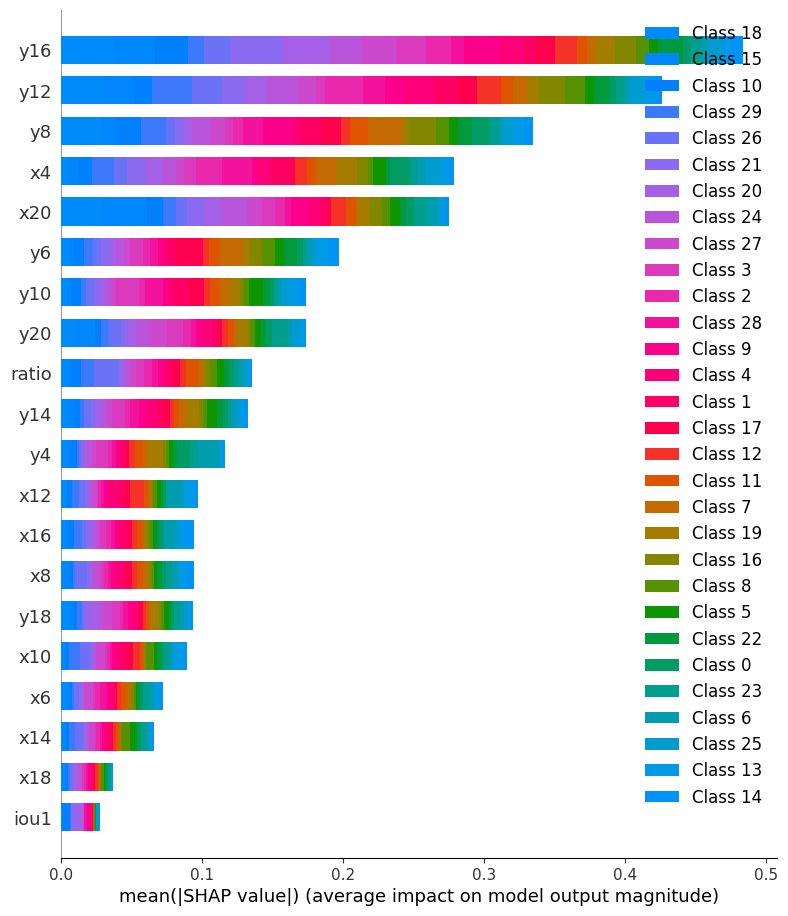

In [73]:
# explainer = shap.Explainer(svc)

# shap_values = explainer(X_train, y_train)
# shap.plots.bar(shap_values)
# plt.show()

background_sample = shap.sample(X_train, 100)  # Using 100 as an example

# Create a SHAP explainer using KernelExplainer
explainer = shap.TreeExplainer(rfc_fin, background_sample)

# Compute SHAP values
shap_values = explainer.shap_values(X_train)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_train)

In [67]:
get_stratified_shuffle_split_score(rfc_opt)
get_repeated_stratified_kfold_score(rfc_opt)

CV with stratified shuffle split:
Mean accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.01

Mean f1_macro: 0.97
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.01

Mean f1_macro: 0.97
Standard deviation: 0.01



In [69]:
pickle.dump(rfc_fin, open('model_fin.pkl','wb'))

In [71]:
rfc_fin.score(X_train, y_train)

0.9872448979591837

In [26]:
rfc_opt = RandomForestClassifier(criterion = 'entropy',
                                 max_depth = 11,
                                 max_features = 'sqrt',
                                 min_samples_leaf = 1,
                                 min_samples_split = 3,
                                 n_estimators = 500)

In [91]:
def get_repeated_stratified_kfold_accuracy(model):
    cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 42)
    scores = cross_validate(model, X_train, y_train, cv = cv, 
                            scoring = ['accuracy'] )
    return scores['test_accuracy'].mean()

In [28]:
rfc_opt = rfc_opt.fit(X_train, y_train)

In [30]:
rfc_opt.score(X_train, y_train)

0.9997165532879818

In [44]:
# get_stratified_shuffle_split_score(rfc_opt)
# get_repeated_stratified_kfold_score(rfc_opt)

In [36]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the hyperparameter space
space = {
    # 'criterion': hp.choice('criterion', ['entropy', 'gini']),
    'max_depth': hp.choice('max_depth', np.arange(5, 14, dtype=int)),
    'max_features': hp.choice('max_features', ['sqrt', 'log2', None]),
    'min_samples_leaf': hp.choice('min_samples_leaf,', np.arange(1, 14, dtype=int)),
    'min_samples_split': hp.choice('min_samples_split,', np.arange(2, 10, dtype=int)),
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200, 500])
}

# Define the objective function
def objective(space):
    model = RandomForestClassifier(
        # criterion=space['criterion'],
        max_depth=int(space['max_depth']),
        max_features=space['max_features'],
        min_samples_leaf=int(space['min_samples_leaf']),
        min_samples_split=int(space['min_samples_split']),
        n_estimators=space['n_estimators']
    )
    
    # accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()
    accuracy = get_repeated_stratified_kfold_accuracy(model)
    
    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK}

# Perform hyperparameter optimizationj
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("The best hyperparameters are: ", best_hyperparams)
# The best hyperparameters are:  {'criterion': 1, 'max_depth': 8, 'max_features': 0, 'min_samples_leaf': 12, 'n_estimators': 3}


100%|████████| 10/10 [40:35<00:00, 243.53s/trial, best loss: -0.9560657596371883]
The best hyperparameters are:  {'max_depth': 7, 'max_features': 1, 'min_samples_leaf,': 3, 'min_samples_split,': 0, 'n_estimators': 2}


In [37]:
rfc_opt2 = RandomForestClassifier(
                                 max_depth = 11,
                                 max_features = 'log2',
                                 min_samples_leaf = 4,
                                 min_samples_split = 2,
                                 n_estimators = 100)

In [39]:
rfc_opt2 = rfc_opt2.fit(X_train, y_train)

In [41]:
rfc_opt2.score(X_train, y_train)

0.9903628117913832

In [42]:
get_stratified_shuffle_split_score(rfc_opt2)
get_repeated_stratified_kfold_score(rfc_opt2)

CV with stratified shuffle split:
Mean accuracy: 0.96
Standard deviation: 0.01

Mean precision_macro: 0.96
Standard deviation: 0.01

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01

CV with repeated stratified kfold:
Mean accuracy: 0.95
Standard deviation: 0.01

Mean precision_macro: 0.96
Standard deviation: 0.01

Mean recall_macro: 0.96
Standard deviation: 0.01

Mean f1_macro: 0.96
Standard deviation: 0.01



In [74]:
from sklearn.ensemble import AdaBoostClassifier

### AdaBoost ###

In [85]:
estimator = tree.DecisionTreeClassifier(max_depth=9)
ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
ada = ada.fit(X_train, y_train)

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


In [86]:
ada.score(X_train, y_train)

1.0

In [87]:
get_stratified_shuffle_split_score(ada)
get_repeated_stratified_kfold_score(ada)

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


CV with stratified shuffle split:
Mean accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.01

Mean f1_macro: 0.97
Standard deviation: 0.01



`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
`base_estimator` was renamed to `estimator`

CV with repeated stratified kfold:
Mean accuracy: 0.97
Standard deviation: 0.01

Mean precision_macro: 0.97
Standard deviation: 0.01

Mean recall_macro: 0.97
Standard deviation: 0.00

Mean f1_macro: 0.97
Standard deviation: 0.00



In [88]:
pickle.dump(ada, open('model_ada.pkl','wb'))

# Conclusion and room for growth #

The model recognizes most of the letters and, as expected, struggles the most with those that differ in movement, rather than shape. It does well with small variations in angle, however, more training data could be collected to improve that even further. It performs not too slow in real time (despite the code for real-time not being optimized at all yet). 
There are more things that can be explored and tweaked like how many frames apart should the samples be taken, for many frames back should the IoU be taken or maybe even a more complex way of modelling that would classify among the static letters first and then classify movement. 

### References: ###
<ol>
    <li><a href="https://www.youtube.com/watch?v=8YmTxIp2Gtg">Bulgarian Sign Language Youtube</a></li>
    <li><a href="https://ai.google.dev/edge/mediapipe/solutions/vision/hand_landmarker">Mediapipe Hand Landmarker</a></li>
</ol>